# Setup

In [ ]:
!pip install pytorch_metric_learning
!pip install faiss-gpu
# !pip install faiss-cpu

     |████████████████████████████████| 112kB 7.4MB/s 
     |████████████████████████████████| 8.2MB 7.1MB/s 


In [ ]:
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader, SequentialSampler, TensorDataset, random_split
from pytorch_metric_learning import losses, miners, reducers, samplers, distances


np.set_printoptions(suppress=True)

In [ ]:
drive.mount('/content/gdrive/')
path = 'gdrive/MyDrive/Programming Projects/Embeddings/data/'

Mounted at /content/gdrive/


In [ ]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu") 

In [ ]:
#HYPERPARAMETERS

np.random.seed(1871)
CHECKPOINT_PATH = path + "model.pt"
LOAD_PICKLED_DATASET = True

#Positive pairs generation
SEQUENCE_LEN = 120
SEQUENCES_PER_CLIENT = 10

#Encoder
EVENT_ENCODING_DIMENSIONS = 32
RNN_HIDDEN_STATE_DIMENSIONS = 256
EVENT_EMBEDDING_DIMENSIONS = 8

EPOCHS = 40
BATCH_SIZE = 128
LEARNING_RATE = 5e-4

#Classifier
CLASSIFIER_LAYER1_DIM = 256
CLASSIFIER_LAYER2_DIM = 256

CLASSIFIER_EPOCHS = 100
CLASSIFIER_BATCH_SIZE = 256
CLASSIFIER_LEARNING_RATE = 1e-4



# Data

In [ ]:
def subsequence_generator(sequence, pad_vector, to_generate=10, length=120):
    start_idx = np.random.randint(0, len(sequence) - 1, size=to_generate)
    ret = np.tile(pad_vector, (to_generate, length, 1))

    for i, idx in enumerate(start_idx):
        subsequence = sequence[idx:]
        ret[i, 0:subsequence.shape[0]] = subsequence[:min(len(subsequence), length)]

    return ret

In [ ]:
class TransactionDataset(Dataset):
    def __init__(self, data, num_subsequences=10, subsequence_len=120):
        self.clients = data['client_id'].unique()
        

        data['small_group'] = data['small_group'] + 1 # allowing us to use "0" as padding

        data['trans_date'] = pd.to_datetime(data['trans_date'], unit='d')
        data['day_of_week'] = data['trans_date'].dt.dayofweek + 1
        data['month'] = data['trans_date'].dt.month
        data = data.drop(columns=['trans_date'])

        data=data.reindex(columns=['client_id','small_group', 'day_of_week', 'month', 'amount_rur'])


        pad_sequence = np.array([0,0,0,0.])

        self.data = list()
        for i, client in enumerate(self.clients):
            sequence = data[data['client_id'] == client].drop(columns=['client_id']).to_numpy()
            self.data.append(subsequence_generator(sequence, pad_sequence, num_subsequences, subsequence_len))
            
        self.data = np.array(self.data)
        

    def __len__(self):
        return self.clients.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.clients[idx]

In [ ]:
df = pd.read_csv(path + "transactions_train.csv")


if LOAD_PICKLED_DATASET:
    train_dataset = pickle.load(open(path + "unsupervised_train_dataset.p", "rb" ))
    test_dataset = pickle.load(open(path + "unsupervised_test_dataset.p", "rb" ))
else:
    test_clients = np.random.choice(df.client_id.unique(), size=int(0.2 * df.client_id.nunique()), replace=False)
    train_clients = np.array(list(set(df.client_id.unique()) - set(test_clients)))
    train_idx = ~df.client_id.isin(test_clients)

    df_train = df[train_idx].copy()
    df_test = df[~train_idx].copy()
    train_dataset = TransactionDataset(df_train, 
                                    num_subsequences=SEQUENCES_PER_CLIENT,
                                    subsequence_len=SEQUENCE_LEN)
    pickle.dump(train_dataset, open(path + "unsupervised_train_dataset.p", "wb" ) )

    test_dataset = TransactionDataset(df_test, 
                                    num_subsequences=SEQUENCES_PER_CLIENT,
                                    subsequence_len=SEQUENCE_LEN)
    pickle.dump(test_dataset, open(path + "unsupervised_test_dataset.p", "wb" ) )


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_sampler = samplers.MPerClassSampler(train_dataset.clients, 1, batch_size=BATCH_SIZE, length_before_new_iter=len(train_dataset))
test_sampler = samplers.MPerClassSampler(test_dataset.clients, 1, batch_size=BATCH_SIZE, length_before_new_iter=len(test_dataset))

print(len(train_dataset), len(test_dataset))

24000 6000


# Encoder


In [ ]:
class EventEncoder(nn.Module):
    def __init__(self, num_features, cat_features, cat_vocab_sizes, out_dim, emb_dim=32):
        super(EventEncoder, self).__init__()

        self.initial_norm = nn.BatchNorm1d(num_features, affine=False)

        # len(nn.ModuleList) is a bit wacky, so we'll store the size just in case
        self.embeddings = nn.ModuleList() 
        self.cat_features = cat_features 
        for i in range(cat_features):
            self.embeddings.append(nn.Embedding(cat_vocab_sizes[i], emb_dim, padding_idx=0))

        cur_size = emb_dim * cat_features + num_features
        self.process = nn.Sequential(
            nn.Linear(cur_size, out_dim),
            nn.Sigmoid(),
            nn.BatchNorm1d(out_dim),
        )

    def forward(self, numerical, categorical):
        concat_input = self.initial_norm(numerical)

        for i in range(self.cat_features):
            embedded_cat = self.embeddings[i](categorical[:,i])
            concat_input = torch.cat((concat_input, embedded_cat), 1)
        out = self.process(concat_input)
        
        return out

In [ ]:
class SequenceEncoder(nn.Module):
    def __init__(self, num_features, cat_features, cat_vocab_sizes, sequence_len, event_dim=128, hidden_size=128, event_emb_dim=32):

        super(SequenceEncoder, self).__init__()

        self.num_features = num_features
        self.cat_features = cat_features
        self.sequence_len = sequence_len
        self.event_dim = event_dim

        self.event_encoder = EventEncoder(num_features, cat_features, cat_vocab_sizes, event_dim, emb_dim=event_emb_dim)

        self.rnn = nn.GRU(event_dim, hidden_size, batch_first=True)

                     
    def forward(self, numerical, categorical):
        # numerical of size (batch_size, num_of_sequences, sequence_len, num_features)
        # categorical of size (batch_size, num_of_sequences, sequence_len, cat_features)

        numerical = numerical.view(-1, self.num_features)
        categorical = categorical.view(-1, self.cat_features)
        
        # receiving batch_size x num_of_sequences x sequence_len x event_dim events
        events = self.event_encoder(numerical, categorical)
        events = events.view(-1, self.sequence_len, self.event_dim)

        #taking the output of the last cell        
        out = self.rnn(events)[0][:,-1,:]
        
        return out

In [ ]:
encoder = SequenceEncoder(num_features=1, 
                          cat_features=3, 
                          cat_vocab_sizes=[df['small_group'].max() + 2, 8, 13], # +1 for padding 
                          sequence_len=SEQUENCE_LEN, 
                          event_dim=EVENT_ENCODING_DIMENSIONS, 
                          hidden_size=RNN_HIDDEN_STATE_DIMENSIONS,
                          event_emb_dim=EVENT_EMBEDDING_DIMENSIONS)

encoder.to(device)

optimizer = torch.optim.AdamW(encoder.parameters(), lr=LEARNING_RATE)

reduce_func = reducers.AvgNonZeroReducer()
distance_func = distances.LpDistance()
loss_func = losses.TripletMarginLoss(margin=0.3, distance = distance_func, reducer = reduce_func)
miner_func = miners.TripletMarginMiner(margin=0.3, distance = distance_func, type_of_triplets="semihard")

categorical_mask = [True, True, True, False]

In [ ]:
train_loss_history = list()
val_loss_history = list()


for epoch in tqdm(range(EPOCHS)):
    cur_losses = list()

    encoder.train()
    for batch_idx, (sequences, labels) in enumerate(train_dataloader):
        
        numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
        categorical = sequences[:,:,:,categorical_mask].to(device)
        
        labels = np.repeat(labels, SEQUENCES_PER_CLIENT).to(device)

        embeddings = encoder(numerical.float(), categorical.int()).to(device)
        mining = miner_func(embeddings, labels)
        train_loss = loss_func(embeddings, labels, mining)

        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        cur_losses.append(train_loss.item())

    train_loss_history.append(np.mean(cur_losses))

    cur_losses = list()

    encoder.eval()
    for batch_idx, (sequences, labels) in enumerate(test_dataloader):

        numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
        categorical = sequences[:,:,:,categorical_mask].to(device)

        labels = np.repeat(labels, SEQUENCES_PER_CLIENT).to(device)

        with torch.no_grad():
            embeddings = encoder(numerical.float(), categorical.int()).to(device)
            mining = miner_func(embeddings, labels)
            val_loss = loss_func(embeddings, labels, mining)

            cur_losses.append(val_loss.item())

    val_loss_history.append(np.mean(cur_losses))

    print("\nEpoch {}; Train loss = {}; Val loss = {}".format(epoch+1, train_loss_history[-1], val_loss_history[-1]))

    torch.save({
            'epoch': epoch,
            'model_state_dict': encoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_history[-1],
            }, CHECKPOINT_PATH)

  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 1; Train loss = 0.16625371337571043; Val loss = 0.16228689221625633


  3%|▎         | 2/64 [04:37<2:24:00, 139.36s/it]


Epoch 2; Train loss = 0.15947269537347428; Val loss = 0.1565939761856769


  5%|▍         | 3/64 [06:54<2:20:51, 138.55s/it]


Epoch 3; Train loss = 0.1548767070028376; Val loss = 0.1542909208764421


  6%|▋         | 4/64 [09:10<2:17:41, 137.70s/it]


Epoch 4; Train loss = 0.15391254813430158; Val loss = 0.15332157148959788


  8%|▊         | 5/64 [11:25<2:14:49, 137.12s/it]


Epoch 5; Train loss = 0.15258044947652108; Val loss = 0.15161607810791503


  9%|▉         | 6/64 [13:42<2:12:22, 136.93s/it]


Epoch 6; Train loss = 0.148026168980497; Val loss = 0.14355749303990223


 11%|█         | 7/64 [15:57<2:09:40, 136.50s/it]


Epoch 7; Train loss = 0.14141962764428018; Val loss = 0.1404232588854242


 12%|█▎        | 8/64 [18:12<2:07:01, 136.09s/it]


Epoch 8; Train loss = 0.13931827167881297; Val loss = 0.13697667356501234


 14%|█▍        | 9/64 [20:28<2:04:28, 135.80s/it]


Epoch 9; Train loss = 0.13652995981751603; Val loss = 0.13562903505690554


 16%|█▌        | 10/64 [22:42<2:01:44, 135.27s/it]


Epoch 10; Train loss = 0.13565169235176228; Val loss = 0.13572527912068874


 17%|█▋        | 11/64 [24:55<1:59:05, 134.81s/it]


Epoch 11; Train loss = 0.13480601309144752; Val loss = 0.13378043282539287


 19%|█▉        | 12/64 [27:09<1:56:28, 134.39s/it]


Epoch 12; Train loss = 0.1321726016541745; Val loss = 0.1308947062872826


 20%|██        | 13/64 [29:22<1:53:49, 133.91s/it]


Epoch 13; Train loss = 0.13063627362568328; Val loss = 0.12973396067923687


 22%|██▏       | 14/64 [31:35<1:51:24, 133.70s/it]


Epoch 14; Train loss = 0.12830507798873364; Val loss = 0.12752684855714758


 23%|██▎       | 15/64 [33:47<1:48:49, 133.25s/it]


Epoch 15; Train loss = 0.127288481220603; Val loss = 0.12673995532888047


 25%|██▌       | 16/64 [35:59<1:46:18, 132.88s/it]


Epoch 16; Train loss = 0.1265690441223535; Val loss = 0.12575725259933065


 27%|██▋       | 17/64 [38:11<1:43:58, 132.74s/it]


Epoch 17; Train loss = 0.12559227570098766; Val loss = 0.12449126183352571


 28%|██▊       | 18/64 [40:24<1:41:37, 132.56s/it]


Epoch 18; Train loss = 0.12410635505109391; Val loss = 0.12326602336574108


 30%|██▉       | 19/64 [42:35<1:39:17, 132.39s/it]


Epoch 19; Train loss = 0.122698746264932; Val loss = 0.12175938915064995


 31%|███▏      | 20/64 [44:47<1:36:55, 132.16s/it]


Epoch 20; Train loss = 0.12190166242579197; Val loss = 0.1214027426978375


 33%|███▎      | 21/64 [46:59<1:34:36, 132.02s/it]


Epoch 21; Train loss = 0.12114436781786858; Val loss = 0.12089819175765869


 34%|███▍      | 22/64 [49:10<1:32:17, 131.84s/it]


Epoch 22; Train loss = 0.12060888682274108; Val loss = 0.12034695595502853


 36%|███▌      | 23/64 [51:22<1:30:00, 131.72s/it]


Epoch 23; Train loss = 0.1199673002863184; Val loss = 0.11997639752448873


 38%|███▊      | 24/64 [53:33<1:27:39, 131.49s/it]


Epoch 24; Train loss = 0.11939102411270142; Val loss = 0.11906284458459691


 39%|███▉      | 25/64 [55:44<1:25:22, 131.36s/it]


Epoch 25; Train loss = 0.11882944971798583; Val loss = 0.11826733737549883


 41%|████      | 26/64 [57:55<1:23:09, 131.30s/it]


Epoch 26; Train loss = 0.1184467797742245; Val loss = 0.11830399740249553


 42%|████▏     | 27/64 [1:00:06<1:20:51, 131.13s/it]


Epoch 27; Train loss = 0.1180110919348737; Val loss = 0.11795518721671815


 44%|████▍     | 28/64 [1:02:16<1:18:35, 130.99s/it]


Epoch 28; Train loss = 0.11774782792843402; Val loss = 0.11732610045595372


 45%|████▌     | 29/64 [1:04:27<1:16:20, 130.86s/it]


Epoch 29; Train loss = 0.11738292702493515; Val loss = 0.11753104595427817


 47%|████▋     | 30/64 [1:06:37<1:14:06, 130.77s/it]


Epoch 30; Train loss = 0.11710233645553285; Val loss = 0.11756765446130266


 48%|████▊     | 31/64 [1:08:48<1:11:50, 130.63s/it]


Epoch 31; Train loss = 0.11693774163722992; Val loss = 0.11706097852042381


 50%|█████     | 32/64 [1:10:58<1:09:36, 130.50s/it]


Epoch 32; Train loss = 0.11663260564525077; Val loss = 0.11718289839460495


 52%|█████▏    | 33/64 [1:13:08<1:07:23, 130.42s/it]


Epoch 33; Train loss = 0.11635251446290219; Val loss = 0.11643129904219444


 53%|█████▎    | 34/64 [1:15:18<1:05:11, 130.38s/it]


Epoch 34; Train loss = 0.11613090213467465; Val loss = 0.11643382383787886


 55%|█████▍    | 35/64 [1:17:29<1:03:00, 130.35s/it]


Epoch 35; Train loss = 0.11583422421616443; Val loss = 0.11630770817716071


 56%|█████▋    | 36/64 [1:19:39<1:00:48, 130.31s/it]


Epoch 36; Train loss = 0.11565923124076204; Val loss = 0.11551093516197611


 58%|█████▊    | 37/64 [1:21:49<58:38, 130.30s/it]  


Epoch 37; Train loss = 0.11543807490391934; Val loss = 0.11567193491661802


 59%|█████▉    | 38/64 [1:23:59<56:27, 130.28s/it]


Epoch 38; Train loss = 0.11515078598514517; Val loss = 0.11567733151481506


 61%|██████    | 39/64 [1:26:10<54:17, 130.29s/it]


Epoch 39; Train loss = 0.11491943444026277; Val loss = 0.11592633546666896


 62%|██████▎   | 40/64 [1:28:20<52:06, 130.26s/it]


Epoch 40; Train loss = 0.11468583916095977; Val loss = 0.11552763540059963


KeyboardInterrupt: ignored

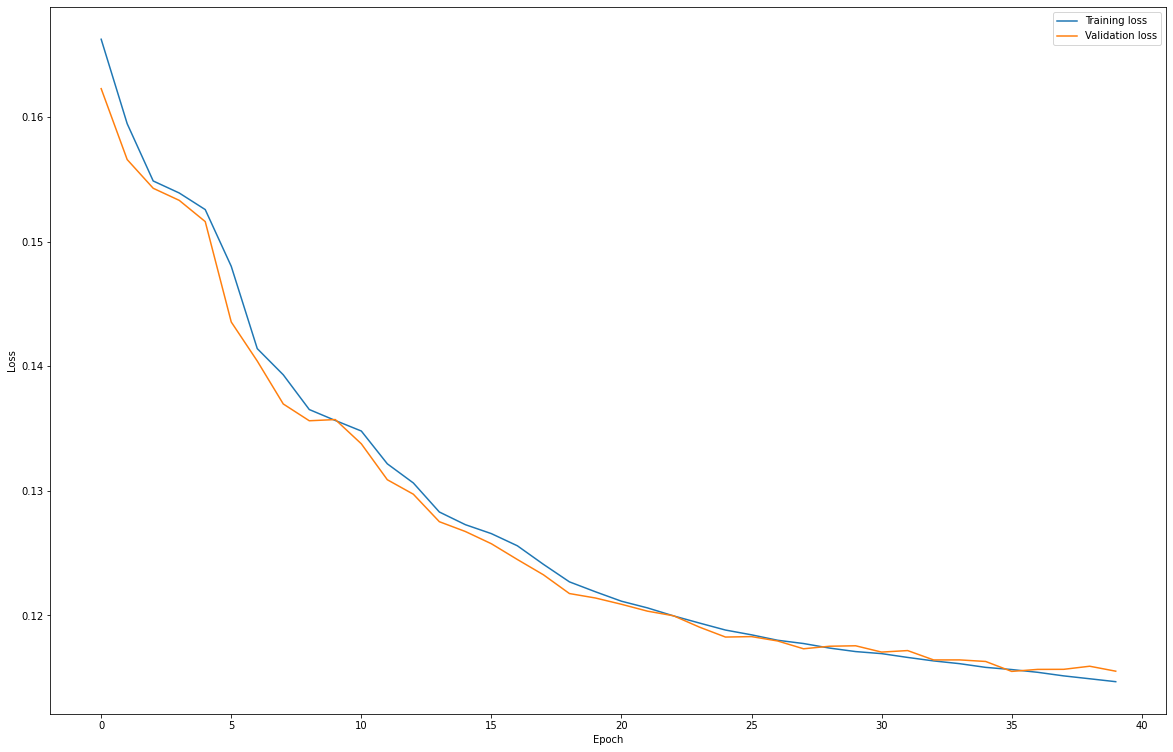

In [ ]:
plt.figure(figsize=(20,13))

plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pickle.dump(embeddings, open(path + "embeddings.p", "wb" ) )

# Classification

In [ ]:
target = pd.read_csv(path + "train_target.csv")  

In [ ]:
target = pd.read_csv(path + "train_target.csv")  
client_target_dict = pd.Series(target.bins.values, index=target.client_id).to_dict()
age_target = np.vectorize(client_target_dict.get)(train_dataset.clients)


predict_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=SequentialSampler(train_dataset))

pred = np.zeros(shape=(len(train_dataset), SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS))
client_targets = np.zeros(shape=len(train_dataset))
age_targets = np.zeros(shape=len(train_dataset))

encoder.eval()
for batch_idx, (sequences, labels) in enumerate(predict_dataloader):
    numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
    categorical = sequences[:,:,:,categorical_mask].to(device)
    labels = labels.numpy()

    with torch.no_grad():
        embeddings = encoder(numerical.float(), categorical.int()).to(device)
    embeddings = embeddings.view(-1, SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS)

    pred[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE, :, :] = embeddings.cpu().numpy()
    client_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = labels
    age_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = np.vectorize(client_target_dict.get)(labels)


train_pred = pred.reshape(-1, RNN_HIDDEN_STATE_DIMENSIONS)
train_client_targets = np.repeat(client_targets, SEQUENCES_PER_CLIENT)
train_age_targets = np.repeat(age_targets, SEQUENCES_PER_CLIENT)

In [ ]:
age_target = np.vectorize(client_target_dict.get)(test_dataset.clients)

predict_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=SequentialSampler(test_dataset))

pred = np.zeros(shape=(len(test_dataset), SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS))
client_targets = np.zeros(shape=len(test_dataset))
age_targets = np.zeros(shape=len(test_dataset))

encoder.eval()
for batch_idx, (sequences, labels) in enumerate(predict_dataloader):
    numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
    categorical = sequences[:,:,:,categorical_mask].to(device)
    labels = labels.numpy()

    with torch.no_grad():
        embeddings = encoder(numerical.float(), categorical.int()).to(device)
    embeddings = embeddings.view(-1, SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS)

    pred[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE, :, :] = embeddings.cpu().numpy()
    client_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = labels
    age_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = np.vectorize(client_target_dict.get)(labels)


test_pred = pred.reshape(-1, RNN_HIDDEN_STATE_DIMENSIONS)
test_client_targets = np.repeat(client_targets, SEQUENCES_PER_CLIENT)
test_age_targets = np.repeat(age_targets, SEQUENCES_PER_CLIENT)

In [ ]:
pred = np.concatenate([train_pred, test_pred])
client_targets = np.concatenate([train_client_targets, test_client_targets])
age_targets = np.concatenate([train_age_targets, test_age_targets])

pickle.dump(pred, open(path + "pred.p", "wb" ) )
pickle.dump(client_targets, open(path + "client_targets.p", "wb" ) )
pickle.dump(age_targets, open(path + "age_targets.p", "wb" ) )

In [ ]:
pred = pickle.load(open(path + "pred.p", "rb" ))
client_targets = pickle.load(open(path + "client_targets.p", "rb" ))
age_targets = pickle.load(open(path + "age_targets.p", "rb" ))

In [ ]:
X = torch.Tensor(pred)
y = torch.Tensor(age_targets)

classifier_dataset = TensorDataset(X, y)
train_classifier_dataset, test_classifier_dataset = random_split(classifier_dataset, [int(len(classifier_dataset) * 0.8), len(classifier_dataset) - (int(len(classifier_dataset) * 0.8))])
train_classifier_dataloader = DataLoader(train_classifier_dataset, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=True)
test_classifier_dataloader = DataLoader(test_classifier_dataset, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=True)

num_classes = target['bins'].nunique()

classifier = nn.Sequential(
    nn.Linear(RNN_HIDDEN_STATE_DIMENSIONS, CLASSIFIER_LAYER1_DIM),
    nn.Sigmoid(),
    nn.BatchNorm1d(CLASSIFIER_LAYER1_DIM),
    nn.Linear(CLASSIFIER_LAYER1_DIM, CLASSIFIER_LAYER2_DIM),
    nn.Sigmoid(),
    nn.BatchNorm1d(CLASSIFIER_LAYER2_DIM),
    nn.Linear(CLASSIFIER_LAYER2_DIM, num_classes),
)
classifier.to(device)

optimizer = torch.optim.AdamW(classifier.parameters(), lr=CLASSIFIER_LEARNING_RATE)

loss_func = nn.CrossEntropyLoss()

In [ ]:
train_loss_history = list()
val_loss_history = list()

train_accuracy_history = list()
val_accuracy_history = list()


for epoch in tqdm(range(CLASSIFIER_EPOCHS)):

    classifier.train()
    cur_losses = list()
    cur_accuracy = list()

    for batch_idx, (sequences, labels) in enumerate(train_classifier_dataloader):

        sequences = sequences.to(device)
        labels = labels.long().to(device)
        
        predictions = classifier(sequences).to(device)
        train_loss = loss_func(predictions, labels)

        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        cur_losses.append(train_loss.item())
        cur_accuracy.append(accuracy_score(torch.argmax(predictions.cpu(), dim=1), labels.cpu()))

    train_loss_history.append(np.mean(cur_losses))
    train_accuracy_history.append(np.mean(cur_accuracy))

    classifier.eval()
    cur_losses = list()
    cur_accuracy = list()

    for batch_idx, (sequences, labels) in enumerate(test_classifier_dataloader):
 
        sequences = sequences.to(device)
        labels = labels.long().to(device)
        with torch.no_grad():
            predictions = classifier(sequences).to(device)
            test_loss = loss_func(predictions, labels)

            cur_losses.append(test_loss.item())
            cur_accuracy.append(accuracy_score(torch.argmax(predictions.cpu(), dim=1), labels.cpu()))

    
    val_loss_history.append(np.mean(cur_losses))
    val_accuracy_history.append(np.mean(cur_accuracy))

    print("\nEpoch {}\n Train Loss = {}\n Train Accuracy = {}\n Validation Loss = {}\n Validation Accuracy = {}".format(
        epoch, train_loss_history[-1], train_accuracy_history[-1], val_loss_history[-1], val_accuracy_history[-1]))

    torch.save({
            'epoch': epoch,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_history[-1],
            }, CHECKPOINT_PATH)


  2%|▏         | 1/64 [00:04<04:25,  4.21s/it]


Epoch 0
 Train Loss = 0.9970711440419846
 Train Accuracy = 0.5490946495202559
 Validation Loss = 0.9826903490310019
 Validation Accuracy = 0.5544824911347519



  3%|▎         | 2/64 [00:08<04:18,  4.18s/it]


Epoch 1
 Train Loss = 0.9783536301874148
 Train Accuracy = 0.5583522121535182
 Validation Loss = 0.9799205031800777
 Validation Accuracy = 0.5568484042553191



  5%|▍         | 3/64 [00:12<04:14,  4.18s/it]


Epoch 2
 Train Loss = 0.9735069977703379
 Train Accuracy = 0.5607051239339019
 Validation Loss = 0.9763268445400481
 Validation Accuracy = 0.5564605496453902



  6%|▋         | 4/64 [00:16<04:08,  4.14s/it]


Epoch 3
 Train Loss = 0.9705911586279554
 Train Accuracy = 0.5623709021855011
 Validation Loss = 0.9753141342325413
 Validation Accuracy = 0.558771054964539



  8%|▊         | 5/64 [00:20<04:03,  4.13s/it]


Epoch 4
 Train Loss = 0.9683480039080069
 Train Accuracy = 0.5636618803304904
 Validation Loss = 0.9741492717824084
 Validation Accuracy = 0.5589926861702128



  9%|▉         | 6/64 [00:24<03:59,  4.13s/it]


Epoch 5
 Train Loss = 0.9666410654719705
 Train Accuracy = 0.5637326759061834
 Validation Loss = 0.971271393907831
 Validation Accuracy = 0.5610926418439716



 11%|█         | 7/64 [00:28<03:54,  4.11s/it]


Epoch 6
 Train Loss = 0.964434119620557
 Train Accuracy = 0.566431236673774
 Validation Loss = 0.9701024717472969
 Validation Accuracy = 0.560832225177305



 12%|█▎        | 8/64 [00:32<03:50,  4.11s/it]


Epoch 7
 Train Loss = 0.9622667404507269
 Train Accuracy = 0.5674640191897654
 Validation Loss = 0.9671857582761886
 Validation Accuracy = 0.5626717641843971



 14%|█▍        | 9/64 [00:37<03:45,  4.10s/it]


Epoch 8
 Train Loss = 0.9606235435903708
 Train Accuracy = 0.5685551039445629
 Validation Loss = 0.9653246727395565
 Validation Accuracy = 0.5634807180851064



 16%|█▌        | 10/64 [00:41<03:42,  4.13s/it]


Epoch 9
 Train Loss = 0.9590738432239622
 Train Accuracy = 0.5686217350746269
 Validation Loss = 0.9639250856764773
 Validation Accuracy = 0.5651540336879434



 17%|█▋        | 11/64 [00:45<03:38,  4.12s/it]


Epoch 10
 Train Loss = 0.9576277146969777
 Train Accuracy = 0.5697794509594882
 Validation Loss = 0.9637178532620694
 Validation Accuracy = 0.5636303191489361



 19%|█▉        | 12/64 [00:49<03:36,  4.16s/it]


Epoch 11
 Train Loss = 0.9556339644928222
 Train Accuracy = 0.5713661047441365
 Validation Loss = 0.9622280661095964
 Validation Accuracy = 0.5647717198581561



 20%|██        | 13/64 [00:53<03:32,  4.18s/it]


Epoch 12
 Train Loss = 0.954130106833952
 Train Accuracy = 0.5718741671108742
 Validation Loss = 0.960937100014788
 Validation Accuracy = 0.5666666666666668



 22%|██▏       | 14/64 [00:58<03:29,  4.20s/it]


Epoch 13
 Train Loss = 0.9524477946478674
 Train Accuracy = 0.5728236607142857
 Validation Loss = 0.9605805303188081
 Validation Accuracy = 0.5672761524822694



 23%|██▎       | 15/64 [01:02<03:24,  4.18s/it]


Epoch 14
 Train Loss = 0.9506062783920435
 Train Accuracy = 0.5739355676972282
 Validation Loss = 0.9592494733790133
 Validation Accuracy = 0.5670378989361702



 25%|██▌       | 16/64 [01:06<03:20,  4.17s/it]


Epoch 15
 Train Loss = 0.9486521716311034
 Train Accuracy = 0.5753139992004265
 Validation Loss = 0.9570856211033273
 Validation Accuracy = 0.5691600177304965



 27%|██▋       | 17/64 [01:10<03:15,  4.15s/it]


Epoch 16
 Train Loss = 0.9470953051088207
 Train Accuracy = 0.5765050306503199
 Validation Loss = 0.9567012239009776
 Validation Accuracy = 0.5671708776595744



 28%|██▊       | 18/64 [01:14<03:10,  4.14s/it]


Epoch 17
 Train Loss = 0.9448609779765611
 Train Accuracy = 0.5777418710021321
 Validation Loss = 0.9555695122860848
 Validation Accuracy = 0.5687222960992907



 30%|██▉       | 19/64 [01:18<03:06,  4.14s/it]


Epoch 18
 Train Loss = 0.9435734826364497
 Train Accuracy = 0.5788246268656716
 Validation Loss = 0.9544270515441895
 Validation Accuracy = 0.5698747783687944



 31%|███▏      | 20/64 [01:22<03:02,  4.14s/it]


Epoch 19
 Train Loss = 0.9414249157219299
 Train Accuracy = 0.5795200892857143
 Validation Loss = 0.9516712315539096
 Validation Accuracy = 0.5720356826241135



 33%|███▎      | 21/64 [01:26<02:57,  4.14s/it]


Epoch 20
 Train Loss = 0.9388486995244585
 Train Accuracy = 0.5812649920042644
 Validation Loss = 0.9524404322847407
 Validation Accuracy = 0.5720578457446809



 34%|███▍      | 22/64 [01:31<02:53,  4.12s/it]


Epoch 21
 Train Loss = 0.9368101805766255
 Train Accuracy = 0.5833138992537313
 Validation Loss = 0.950134358000248
 Validation Accuracy = 0.572905585106383



 36%|███▌      | 23/64 [01:35<02:49,  4.13s/it]


Epoch 22
 Train Loss = 0.93454881695542
 Train Accuracy = 0.5845798907249466
 Validation Loss = 0.9506814401200477
 Validation Accuracy = 0.571985815602837



 38%|███▊      | 24/64 [01:39<02:44,  4.12s/it]


Epoch 23
 Train Loss = 0.9324393163738983
 Train Accuracy = 0.5864872068230277
 Validation Loss = 0.9494346519733997
 Validation Accuracy = 0.5724567819148936



 39%|███▉      | 25/64 [01:43<02:40,  4.13s/it]


Epoch 24
 Train Loss = 0.9302325678278388
 Train Accuracy = 0.5864289045842217
 Validation Loss = 0.9462512794961321
 Validation Accuracy = 0.5749058067375886



 41%|████      | 26/64 [01:47<02:36,  4.11s/it]


Epoch 25
 Train Loss = 0.9273626506964027
 Train Accuracy = 0.5887693230277186
 Validation Loss = 0.9456034962167131
 Validation Accuracy = 0.5756316489361702



 42%|████▏     | 27/64 [01:51<02:31,  4.11s/it]


Epoch 26
 Train Loss = 0.9252395230823997
 Train Accuracy = 0.5891399586886994
 Validation Loss = 0.9440203019913207
 Validation Accuracy = 0.5752327127659574



 44%|████▍     | 28/64 [01:55<02:28,  4.12s/it]


Epoch 27
 Train Loss = 0.9230089279126003
 Train Accuracy = 0.5925964485607675
 Validation Loss = 0.9426072310894094
 Validation Accuracy = 0.5758366578014184



 45%|████▌     | 29/64 [01:59<02:23,  4.09s/it]


Epoch 28
 Train Loss = 0.9203497645443183
 Train Accuracy = 0.5935584355010661
 Validation Loss = 0.9416884883921197
 Validation Accuracy = 0.5775265957446809



 47%|████▋     | 30/64 [02:03<02:19,  4.10s/it]


Epoch 29
 Train Loss = 0.917577016582367
 Train Accuracy = 0.5953491471215352
 Validation Loss = 0.9395575069366617
 Validation Accuracy = 0.5788674645390072



 48%|████▊     | 31/64 [02:08<02:15,  4.11s/it]


Epoch 30
 Train Loss = 0.9152195289699253
 Train Accuracy = 0.5966068097014925
 Validation Loss = 0.9393933646222379
 Validation Accuracy = 0.5778091755319149



 50%|█████     | 32/64 [02:12<02:11,  4.12s/it]


Epoch 31
 Train Loss = 0.9128011813931374
 Train Accuracy = 0.5983350546375267
 Validation Loss = 0.9364420162870529
 Validation Accuracy = 0.5810671542553192



 52%|█████▏    | 33/64 [02:16<02:07,  4.11s/it]


Epoch 32
 Train Loss = 0.9098432382413828
 Train Accuracy = 0.5997384728144989
 Validation Loss = 0.9352703023464122
 Validation Accuracy = 0.5802360372340426



 53%|█████▎    | 34/64 [02:20<02:03,  4.12s/it]


Epoch 33
 Train Loss = 0.9070446551608633
 Train Accuracy = 0.6005588686034116
 Validation Loss = 0.9347291061218749
 Validation Accuracy = 0.5834164450354609



 55%|█████▍    | 35/64 [02:24<01:59,  4.11s/it]


Epoch 34
 Train Loss = 0.9045837956196718
 Train Accuracy = 0.6031907982409381
 Validation Loss = 0.9339395698080671
 Validation Accuracy = 0.5810449911347518



 56%|█████▋    | 36/64 [02:28<01:55,  4.11s/it]


Epoch 35
 Train Loss = 0.9020774999279966
 Train Accuracy = 0.6051439232409381
 Validation Loss = 0.9341913831994889
 Validation Accuracy = 0.5826628989361702



 58%|█████▊    | 37/64 [02:32<01:50,  4.09s/it]


Epoch 36
 Train Loss = 0.8986579362771658
 Train Accuracy = 0.6067222481343284
 Validation Loss = 0.9312961806642248
 Validation Accuracy = 0.582673980496454



 59%|█████▉    | 38/64 [02:36<01:46,  4.11s/it]


Epoch 37
 Train Loss = 0.8969790293082499
 Train Accuracy = 0.6080173907249466
 Validation Loss = 0.930990628485984
 Validation Accuracy = 0.584158909574468



 61%|██████    | 39/64 [02:40<01:43,  4.13s/it]


Epoch 38
 Train Loss = 0.8935534012978519
 Train Accuracy = 0.609329191098081
 Validation Loss = 0.9296771757146145
 Validation Accuracy = 0.584513519503546



 62%|██████▎   | 40/64 [02:45<01:38,  4.12s/it]


Epoch 39
 Train Loss = 0.8912722634227037
 Train Accuracy = 0.6117987073560768
 Validation Loss = 0.9288286424697714
 Validation Accuracy = 0.5858543882978723



 64%|██████▍   | 41/64 [02:49<01:34,  4.12s/it]


Epoch 40
 Train Loss = 0.8880386041171515
 Train Accuracy = 0.6123275919509595
 Validation Loss = 0.9278252150150056
 Validation Accuracy = 0.5845910904255319



 66%|██████▌   | 42/64 [02:53<01:30,  4.09s/it]


Epoch 41
 Train Loss = 0.8855346735479481
 Train Accuracy = 0.6150844549573561
 Validation Loss = 0.9268950619596116
 Validation Accuracy = 0.5861979166666668



 67%|██████▋   | 43/64 [02:57<01:26,  4.10s/it]


Epoch 42
 Train Loss = 0.8823390368586664
 Train Accuracy = 0.6162338419509595
 Validation Loss = 0.9270204361448897
 Validation Accuracy = 0.5864029255319149



 69%|██████▉   | 44/64 [03:01<01:21,  4.07s/it]


Epoch 43
 Train Loss = 0.879906302258404
 Train Accuracy = 0.6180828558102346
 Validation Loss = 0.924788676931503
 Validation Accuracy = 0.588530585106383



 70%|███████   | 45/64 [03:05<01:17,  4.08s/it]


Epoch 44
 Train Loss = 0.8773292934716638
 Train Accuracy = 0.6195820562366737
 Validation Loss = 0.9254269186486589
 Validation Accuracy = 0.5875554078014184



 72%|███████▏  | 46/64 [03:09<01:13,  4.08s/it]


Epoch 45
 Train Loss = 0.8740107171825254
 Train Accuracy = 0.6215143590085288
 Validation Loss = 0.9235157370567322
 Validation Accuracy = 0.5888076241134752



 73%|███████▎  | 47/64 [03:13<01:09,  4.09s/it]


Epoch 46
 Train Loss = 0.8715973326138088
 Train Accuracy = 0.6225596348614072
 Validation Loss = 0.9234865667972159
 Validation Accuracy = 0.5892176418439715



 75%|███████▌  | 48/64 [03:17<01:05,  4.07s/it]


Epoch 47
 Train Loss = 0.8683869513367285
 Train Accuracy = 0.6234799773454158
 Validation Loss = 0.9213203962813032
 Validation Accuracy = 0.5887799202127659



 77%|███████▋  | 49/64 [03:21<01:01,  4.08s/it]


Epoch 48
 Train Loss = 0.8660714117957077
 Train Accuracy = 0.6258120668976546
 Validation Loss = 0.9234385130253244
 Validation Accuracy = 0.5908909574468085



 78%|███████▊  | 50/64 [03:25<00:57,  4.11s/it]


Epoch 49
 Train Loss = 0.8630637382266364
 Train Accuracy = 0.6272904450959488
 Validation Loss = 0.9191175422769912
 Validation Accuracy = 0.5939771719858157



 80%|███████▉  | 51/64 [03:30<00:53,  4.10s/it]


Epoch 50
 Train Loss = 0.8605625279295419
 Train Accuracy = 0.6281982942430704
 Validation Loss = 0.9216390726414133
 Validation Accuracy = 0.5892952127659574



 81%|████████▏ | 52/64 [03:34<00:49,  4.10s/it]


Epoch 51
 Train Loss = 0.8577965757867166
 Train Accuracy = 0.6307635927505331
 Validation Loss = 0.9202487818738248
 Validation Accuracy = 0.5910738031914894



 83%|████████▎ | 53/64 [03:38<00:45,  4.09s/it]


Epoch 52
 Train Loss = 0.8551635549012532
 Train Accuracy = 0.6320170908848614
 Validation Loss = 0.9168584630844441
 Validation Accuracy = 0.5941489361702128



 84%|████████▍ | 54/64 [03:42<00:40,  4.10s/it]


Epoch 53
 Train Loss = 0.852899212636419
 Train Accuracy = 0.6325126599147122
 Validation Loss = 0.9215655291334112
 Validation Accuracy = 0.5919437056737588



 86%|████████▌ | 55/64 [03:46<00:36,  4.08s/it]


Epoch 54
 Train Loss = 0.8494320307840416
 Train Accuracy = 0.6350821228678039
 Validation Loss = 0.9194414029730127
 Validation Accuracy = 0.593074024822695



 88%|████████▊ | 56/64 [03:50<00:32,  4.10s/it]


Epoch 55
 Train Loss = 0.8472020231457408
 Train Accuracy = 0.6361815365138592
 Validation Loss = 0.9167608918027675
 Validation Accuracy = 0.5949855939716311



 89%|████████▉ | 57/64 [03:54<00:28,  4.09s/it]


Epoch 56
 Train Loss = 0.8444760100546677
 Train Accuracy = 0.6377681902985075
 Validation Loss = 0.923562633230331
 Validation Accuracy = 0.5903313386524822



 91%|█████████ | 58/64 [03:58<00:24,  4.11s/it]


Epoch 57
 Train Loss = 0.8419274121586448
 Train Accuracy = 0.6387676572494669
 Validation Loss = 0.9189922487482112
 Validation Accuracy = 0.5945921985815603



 92%|█████████▏| 59/64 [04:02<00:20,  4.13s/it]


Epoch 58
 Train Loss = 0.8388812059659694
 Train Accuracy = 0.6403085021321961
 Validation Loss = 0.9180890481522743
 Validation Accuracy = 0.5937444592198582



 94%|█████████▍| 60/64 [04:06<00:16,  4.12s/it]


Epoch 59
 Train Loss = 0.8369316645522615
 Train Accuracy = 0.6420867204157783
 Validation Loss = 0.9150845563158075
 Validation Accuracy = 0.5954399379432624



 95%|█████████▌| 61/64 [04:11<00:12,  4.11s/it]


Epoch 60
 Train Loss = 0.8339442406127702
 Train Accuracy = 0.6430278851279317
 Validation Loss = 0.9153036168281068
 Validation Accuracy = 0.5951906028368795



 97%|█████████▋| 62/64 [04:15<00:08,  4.10s/it]


Epoch 61
 Train Loss = 0.8318605825209668
 Train Accuracy = 0.6440898187633263
 Validation Loss = 0.917477404563985
 Validation Accuracy = 0.5971021719858157



 98%|█████████▊| 63/64 [04:19<00:04,  4.10s/it]


Epoch 62
 Train Loss = 0.8297399488974736
 Train Accuracy = 0.6457014592217484
 Validation Loss = 0.91858265704297
 Validation Accuracy = 0.5930296985815604



100%|██████████| 64/64 [04:23<00:00,  4.11s/it]


Epoch 63
 Train Loss = 0.8270446111017199
 Train Accuracy = 0.646659281716418
 Validation Loss = 0.9188440855513228
 Validation Accuracy = 0.5953457446808511


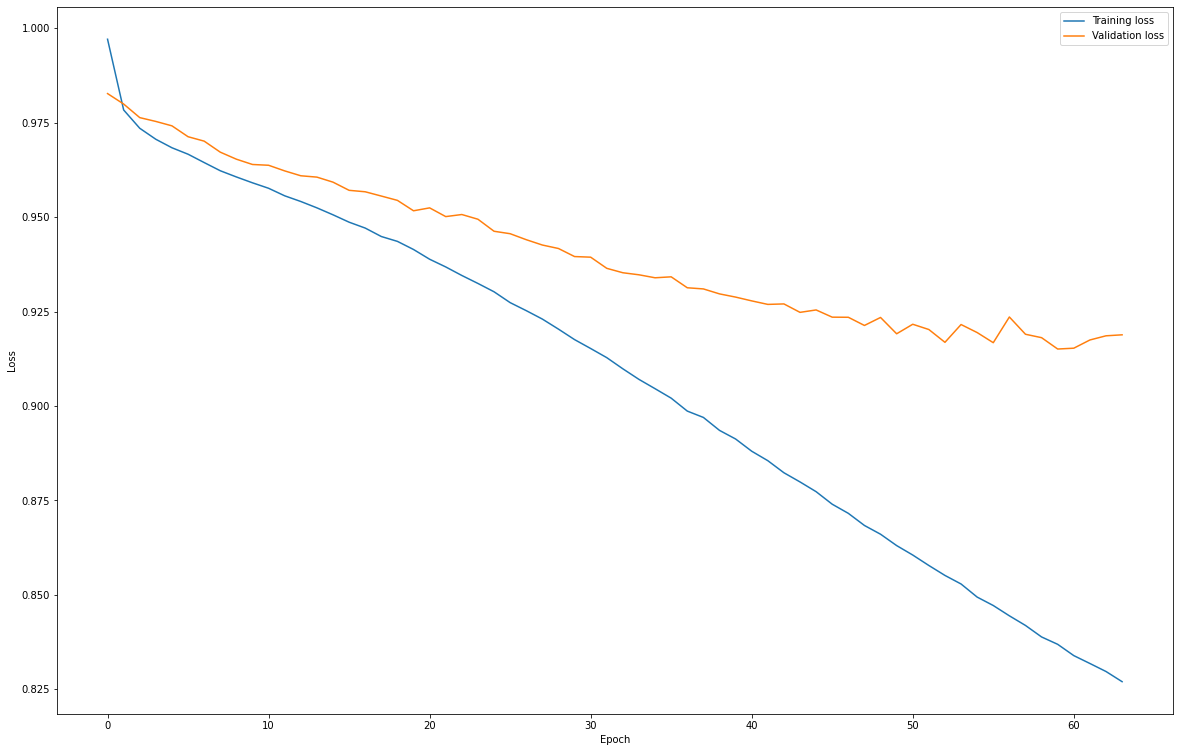

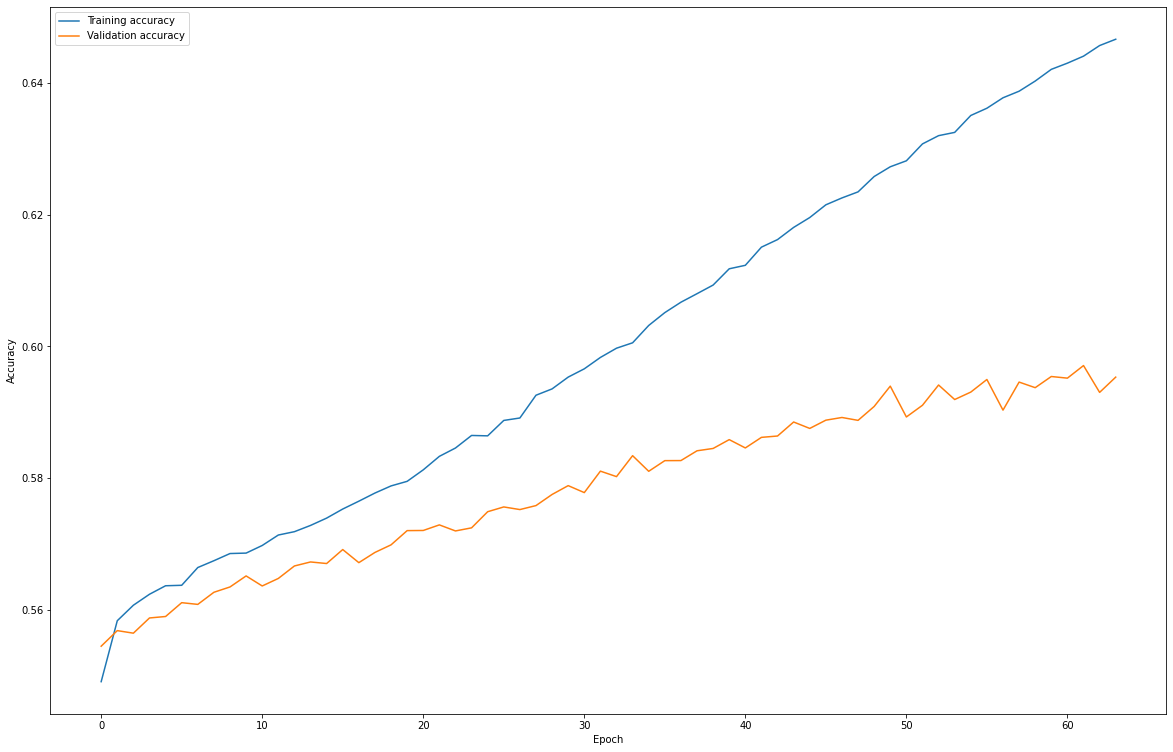

In [ ]:
plt.figure(figsize=(20,13))

plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(20,13))

plt.plot(train_accuracy_history, label='Training accuracy')
plt.plot(val_accuracy_history, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()